In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

df_new = pd.read_csv("vae_imputed.csv")

# Preparing dataframes separately for Targets 1,2 and 3

In [19]:
df1 = df_new.drop(columns=['Target 2','Target 3'])
df2 = df_new.drop(columns=['Target 1','Target 3'])
df3 = df_new.drop(columns=['Target 1','Target 2'])


In [20]:
df1 = df1[~(df1['Target 1'].isna() & (df1['Year'] <= 2023))].copy()
df2 = df2[~(df2['Target 2'].isna() & (df2['Year'] <= 2022))].copy()
df3 = df3[~(df3['Target 3'].isna() & (df3['Year'] <= 2021))].copy()

In [42]:
excluded_indices = {13, 23, 24, 25, 26, 27}
feature_cols = [f'Feature{i}' for i in range(1, 29) if i not in excluded_indices]
sector_cols = [col for col in df_new.columns if col.startswith('sector_')]

# DataPreprocessing for Model

In [43]:
def prepare_data(df, target_col, start_year=1999, end_year=2022):
    # Exclude specific feature columns


    # Filter dataframe for the given year range
    df_filtered = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()
    df_filtered = df_filtered.drop(columns=['Year'])

    # Dataset Class
    class CompanyDataset(Dataset):
        def __init__(self, df, feature_cols, sector_cols, target_col, start_year=1999, end_year=2022):
            self.df = df
            self.feature_cols = feature_cols
            self.sector_cols = sector_cols
            self.target_col = target_col
            self.start_year = start_year
            self.end_year = end_year
            self.total_years = end_year - start_year + 1
            self.company_ids = df['Company'].unique()

        def __len__(self):
            return len(self.company_ids)

        def __getitem__(self, idx):
            company = self.company_ids[idx]
            company_data = self.df[self.df['Company'] == company]

            features = company_data[self.feature_cols + self.sector_cols].values
            target = company_data[self.target_col].values.astype(float)

            num_years = len(company_data)
            padding_years = self.total_years - num_years

            features = np.pad(features, ((0, padding_years), (0, 0)),
                              mode='constant', constant_values=-999)
            target = np.pad(target, (0, padding_years),
                            mode='constant', constant_values=np.nan)

            # Mask is now only for padding (True = real data, False = padded data)
            mask = np.zeros(self.total_years, dtype=bool)
            mask[:num_years] = True

            return {
                'features': torch.tensor(features, dtype=torch.float32),
                'targets': torch.tensor(target, dtype=torch.float32),
                'mask': torch.tensor(mask, dtype=torch.bool)
            }

    # Train-Validation Split
    train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

    # Create datasets and loaders
    train_dataset = CompanyDataset(train_df, feature_cols, sector_cols, target_col)
    val_dataset = CompanyDataset(val_df, feature_cols, sector_cols, target_col)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    return train_loader, val_loader


In [44]:
train_loader, val_loader = prepare_data(df1, target_col='Target 1', start_year=1999, end_year=2023)

# Transformer Architecture And Training

In [33]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MarketCapTransformer(nn.Module):
    def __init__(self, feature_dim=22, sector_dim=13, d_model=64, nhead=4, num_layers=2, dropout=0.1, max_len=25, output_activation=None):
        super(MarketCapTransformer, self).__init__()

        self.input_projection = nn.Linear(feature_dim + sector_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, 1)

        if output_activation == 'relu':
            self.output_activation = nn.ReLU()
        elif output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        else:
            self.output_activation = None

    def forward(self, features, mask):
        # Project input features to model dimension
        x = self.input_projection(features)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Create padding mask: False means keep, True means ignore (standard for PyTorch Transformer)
        key_padding_mask = ~mask  # Already a boolean mask (True = real data)

        # Forward pass through Transformer Encoder
        x = self.transformer(x, src_key_padding_mask=key_padding_mask)

        # Final output projection
        output = self.output_layer(x).squeeze(-1)  # Shape: [batch, seq_len]

        if self.output_activation:
            output = self.output_activation(output)

        return output


In [34]:
import torch.optim as optim
import torch.nn as nn

model = MarketCapTransformer(feature_dim=22, sector_dim=12)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

for epoch in range(100):
    model.train()
    running_loss = 0

    for batch in train_loader:
        features = batch['features']
        targets = batch['targets']
        mask = batch['mask']  # True where real data, False where padded

        preds = model(features, mask)

        # Apply mask to predictions and targets
        valid_preds = preds[mask]
        valid_targets = targets[mask]

        if valid_targets.numel() > 0:  # Make sure there's valid data
            loss = criterion(valid_preds, valid_targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            features = batch['features']
            targets = batch['targets']
            mask = batch['mask']

            preds = model(features, mask)

            valid_preds = preds[mask]
            valid_targets = targets[mask]

            if valid_targets.numel() > 0:
                val_loss += criterion(valid_preds, valid_targets).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Val Loss {avg_val_loss:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "MarketCap_Model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss 37095.5938
Epoch 1: Val Loss 40079.8373
Epoch 2: Train Loss 34773.0978
Epoch 2: Val Loss 40425.7511
Epoch 3: Train Loss 36593.4124
Epoch 3: Val Loss 39331.8414
Epoch 4: Train Loss 33988.5101
Epoch 4: Val Loss 38804.6895
Epoch 5: Train Loss 34720.3765
Epoch 5: Val Loss 38623.7932
Epoch 6: Train Loss 34191.6954
Epoch 6: Val Loss 38421.5658
Epoch 7: Train Loss 35180.8399
Epoch 7: Val Loss 38559.4757
Epoch 8: Train Loss 33530.8862
Epoch 8: Val Loss 37747.6516
Epoch 9: Train Loss 33124.7127
Epoch 9: Val Loss 38435.1524
Epoch 10: Train Loss 34575.9897
Epoch 10: Val Loss 38486.6150
Epoch 11: Train Loss 34553.8081
Epoch 11: Val Loss 38394.7182
Epoch 12: Train Loss 32537.9971
Epoch 12: Val Loss 38018.1941
Epoch 13: Train Loss 31926.8977
Epoch 13: Val Loss 37918.6927
Early stopping triggered.


# Inferencing Sectorwise RMSE

Sector-wise RMSE:
Sector 1 RMSE: 69.7666
Sector 2 RMSE: 112.3748
Sector 3 RMSE: 61.3730
Sector 4 RMSE: 87.8151
Sector 5 RMSE: 91.2495
Sector 6 RMSE: 96.6934
Sector 7 RMSE: 108.0369
Sector 8 RMSE: 162.7067
Sector 9 RMSE: 105.3549
Sector 10 RMSE: 128.7092
Sector 11 RMSE: 60.1110
Sector 12 RMSE: 148.3484

Overall Average RMSE: 102.7116


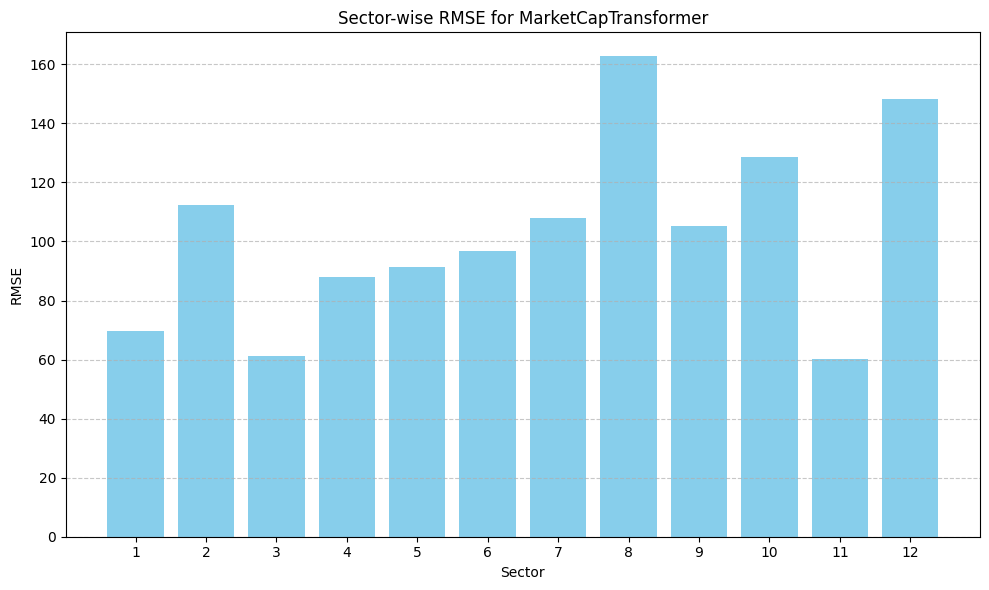

In [35]:

# Initialize your model and load the best weights
model = MarketCapTransformer(feature_dim=22, sector_dim=12)
model.load_state_dict(torch.load("MarketCap_Model.pt"))
model.eval()

# Prepare RMSE dictionary
sector_rmse = {sector: [] for sector in range(1, 13)}

# Validation loop to collect RMSE
with torch.no_grad():
    for batch in val_loader:
        features = batch['features']  # [B, T, feature_dim + sector_dim]
        targets = batch['targets']    # [B, T]
        mask = batch['mask']          # [B, T]

        preds = model(features, mask)

        for sector in range(1, 13):
            # Sector-specific positions
            sector_mask = features[:, :, -12 + sector - 1] == 1
            valid_mask = (mask != -999) & ~torch.isnan(targets) & sector_mask

            if valid_mask.sum() > 0:
                rmse = torch.sqrt(((preds[valid_mask] - targets[valid_mask]) ** 2).mean())
                sector_rmse[sector].append(rmse.item())

# Compute and print the average RMSE per sector
print("Sector-wise RMSE:")
for sector in range(1, 13):
    rmse_list = sector_rmse[sector]
    avg_rmse = np.mean(rmse_list) if rmse_list else float('nan')
    print(f"Sector {sector} RMSE: {avg_rmse:.4f}")

# Calculate overall average (ignoring empty sectors)
all_rmse_values = [np.mean(rmses) for rmses in sector_rmse.values() if rmses]
overall_avg_rmse = np.mean(all_rmse_values)

print(f"\nOverall Average RMSE: {overall_avg_rmse:.4f}")

# Plotting the RMSE
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), [np.mean(sector_rmse[sector]) if sector_rmse[sector] else 0 for sector in range(1, 13)], color='skyblue')
plt.xlabel("Sector")
plt.ylabel("RMSE")
plt.title("Sector-wise RMSE for MarketCapTransformer")
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Predicting Target Values

In [40]:
import torch
import pandas as pd
import numpy as np

def predict_target(df, model, target_col, feature_cols, sector_cols, start_year=1999, end_year=2023):
    # Filter rows where the target column is NaN
    nan_target_df = df[df[target_col].isna()].copy()

    # Prepare list for results
    prediction_results = []

    with torch.no_grad():
        for idx, row in nan_target_df.iterrows():
            company = row['Company']
            # Get historical data up to the relevant year for the target
            company_history = df[(df['Company'] == company) & (df['Year'] <= end_year)].copy()
            if company_history.empty:
                continue  # Skip if no past data

            # Prepare features for the current row
            features = company_history[feature_cols + sector_cols].values
            num_years = len(company_history)
            total_years = end_year - start_year + 1  # Should be 25 for target1, 2022 for target2, etc.
            padding_years = total_years - num_years

            # Pad features to fixed size
            features_padded = np.pad(features, ((0, padding_years), (0, 0)),
                                     mode='constant', constant_values=-999)

            features_tensor = torch.tensor(features_padded, dtype=torch.float32).unsqueeze(0)  # [1, total_years, input_dim]
            mask_tensor = torch.tensor([[True] * num_years + [False] * padding_years], dtype=torch.bool)

            # Predict
            predictions = model(features_tensor, mask_tensor).squeeze(0).numpy()

            # Take prediction at the last known point for the current row
            predicted_value = predictions[num_years - 1]

            # Store prediction
            prediction_results.append({
                'Company': company,
                'Year': row['Year'],
                f'Predicted_{target_col}': predicted_value
            })

    # Create a DataFrame of predictions
    predicted_df = pd.DataFrame(prediction_results)

    return predicted_df


In [41]:
# Predict for Target 1 (using df1, and adjust start_year and end_year as needed)
predicted_target1_df = predict_target(df1, model, target_col='Target 1', feature_cols=feature_cols, sector_cols=sector_cols, start_year=1999, end_year=2023)

# Show the result for Target 1 predictions
print(predicted_target1_df)


             Company  Year  Predicted_Target 1
0            360 ONE  2024          -25.039745
1           3M India  2024          -11.474652
2     5Paisa Capital  2024           40.233414
3     63 Moons Tech.  2024          106.619217
4              A B B  2024          -10.207618
...              ...   ...                 ...
1038    TTK Prestige  2024            2.235979
1039    TVS Holdings  2024           -7.602398
1040   TVS Motor Co.  2024           -7.132694
1041   TVS Srichakra  2024           10.705166
1042   TajGVK Hotels  2024           -3.887965

[1043 rows x 3 columns]
